In [4]:
import numpy as np
import matplotlib.pyplot as plt
from geometry_tools import hyperbolic, drawtools, coxeter, automata, representation
from numpy import pi, log

# Mangahas Group
rep = representation.Representation()
rep["a"] = np.array([[3, 0], [0, 1/3]], dtype=np.float64)
rep["b"] = np.array([[5/3, 4/3], [4/3, 5/3]], dtype=np.float64)

In [1]:
print("Hello World")

Hello World


In [5]:
pos_isometries = rep.freely_reduced_elements(10)
basepoint = 0 + 1j

def mobius_transform(mat, pt):
    return (mat[0,0]*pt + mat[0,1]) / (mat[1,0]*pt + mat[1,1])
    
orbit = [mobius_transform(mat, basepoint) for mat in pos_isometries]

In [6]:
orbit = [[pt.real, pt.imag] for pt in orbit]
orbit = [hyperbolic.Point(pt, model="halfplane") for pt in orbit]
basepoint = hyperbolic.Point((0,1), model="halfplane")
len(orbit)

118097

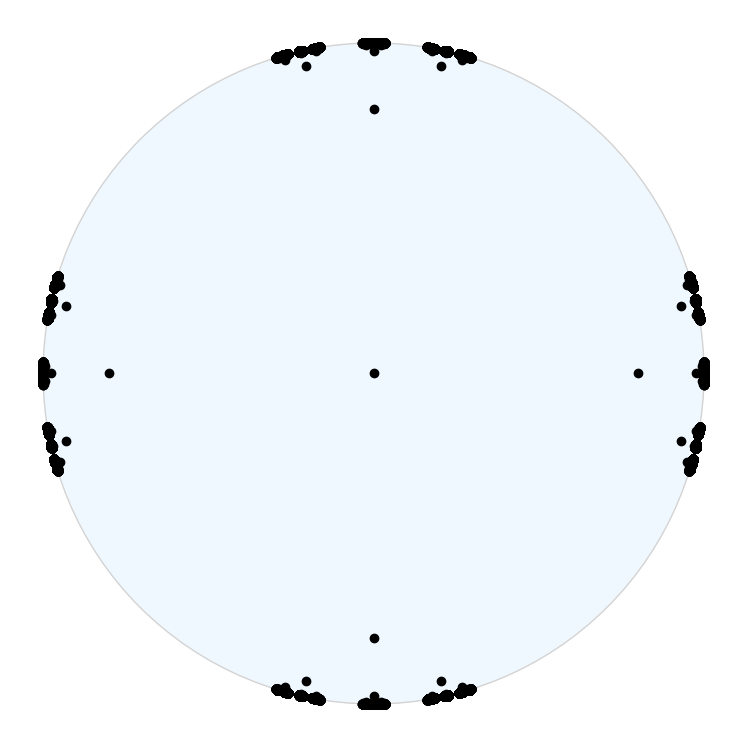

In [7]:
figure = drawtools.HyperbolicDrawing()
figure.draw_plane()
for pt in orbit:
    figure.draw_point(pt)

118097


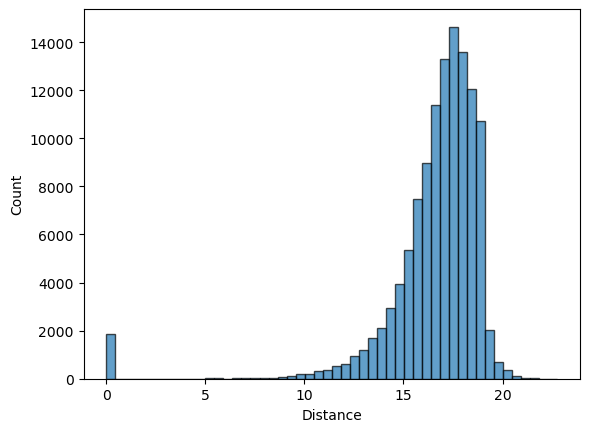

In [8]:
distances = [basepoint.distance(pt) for pt in orbit]
print(len(distances))
plt.hist(distances, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Distance')
plt.ylabel('Count')
plt.show()

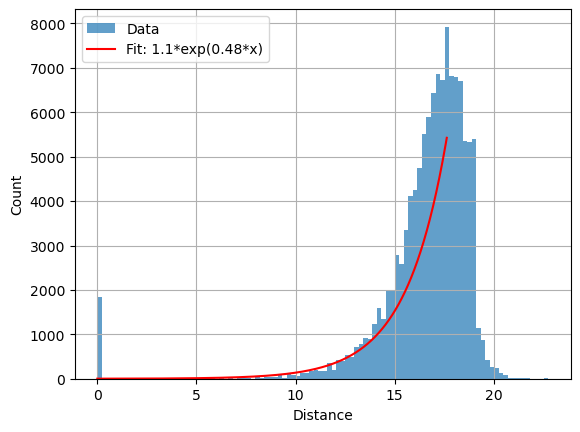

Fitted parameters: a = 1.09, b = 0.48


In [9]:
# Create histogram
counts, bins, _ = plt.hist(distances, bins=100, density=False, alpha=0.7, label='Data')
bin_centers = (bins[:-1] + bins[1:]) / 2

# Find peak index and use only data before it
peak_idx = np.argmax(counts)
x = bin_centers[:peak_idx+1]  # include the peak
counts_before_peak = counts[:peak_idx+1]

# Take logs of positive counts before peak
mask = counts_before_peak > 0
log_counts = np.log(counts_before_peak[mask])
x = x[mask]

# Fit line to log data
coeffs = np.polyfit(x, log_counts, 1)

# Convert back to exponential parameters
a = np.exp(coeffs[1])  # y-intercept becomes exp coefficient
b = coeffs[0]          # slope stays the same

# Generate points for the fitted curve
x_fit = np.linspace(min(bins), bin_centers[peak_idx], 1000)
y_fit = a * np.exp(b * x_fit)

# Plot original histogram and fit
plt.plot(x_fit, y_fit, 'r-', label=f'Fit: {a:.1f}*exp({b:.2f}*x)')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

print(f"Fitted parameters: a = {a:.2f}, b = {b:.2f}")

In [10]:
crit_exp = b
# Filter to unit interval
filtered = [point for point in orbit if abs(point.halfspace_coords()[0]) < 1 and abs(point.halfspace_coords()[0]) < 1e-3]
print(len(filtered))

1105


In [11]:
dirac_sum = sum(np.exp(-crit_exp * basepoint.distance(point)) for point in filtered)
normalized = sum(np.exp(-crit_exp * basepoint.distance(point)) for point in orbit)
measure = dirac_sum / normalized
measure

0.002258797674314639

In [16]:
import numpy as np

# Partition intervals (boundary of the Markov partition)
partitions = [(-np.inf, -1), (-1, 0), (0, 1), (1, np.inf)]
regions = ["P1", "P2", "P3", "P4"]  # Labels for regions

# Determine which region a point belongs to
def get_region(z, partitions):
    """Return the region in the Markov partition corresponding to the real part of z."""
    x = z.real  # Use the real part for boundary partitioning
    for i, (start, end) in enumerate(partitions):
        if start < x <= end:
            return regions[i]
    return None

# Recursive computation of inverse images and transition matrix
def compute_transition_matrix(isometries, partitions, iterations=5):
    """
    Compute the transition matrix T_ij for a Markov partition.
    T_ij counts transitions between regions under inverse images of mappings.
    """
    num_regions = len(partitions)
    T = np.zeros((num_regions, num_regions))  # Transition matrix

    # Iterate to refine the partition
    for _ in range(iterations):
        for i, region_i in enumerate(partitions):
            for j, region_j in enumerate(partitions):
                # Check if the inverse image of region_j intersects region_i
                for key, matrix in isometries:
                    inverse_images = [mobius_transform(np.linalg.inv(matrix), x) for x in np.linspace(*region_j, 10)]
                    if any(region_i[0] < img.real <= region_i[1] for img in inverse_images):
                        T[i, j] += 1  # Increment transition count

    return T

# Compute invariant measure from the largest eigenvector of T
def compute_invariant_measure(transition_matrix):
    """Compute the invariant measure using the Perron-Frobenius eigenvector."""
    eigenvalues, eigenvectors = np.linalg.eig(transition_matrix.T)
    max_index = np.argmax(np.real(eigenvalues))
    largest_eigenvector = np.real(eigenvectors[:, max_index])
    return largest_eigenvector / np.sum(largest_eigenvector)

# Example usage:
# Compute the transition matrix for 5 iterations
transition_matrix = compute_transition_matrix(pos_isometries, partitions, iterations=5)

# Compute the invariant measure
invariant_measure = compute_invariant_measure(transition_matrix)

# Display results
print("Transition Matrix:")
print(transition_matrix)
print("\nInvariant Measure:")
for i, measure in enumerate(invariant_measure):
    print(f"Region {regions[i]}: {measure:.4f}")

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional